In [1]:
# Pathway stats
import utils
import process_datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import gridspec
import matplotlib.patches as mpatches
import scipy.stats as stats
import statsmodels.api as sm
import itertools
import pickle

In [7]:
KEGG_pathway_df = pd.read_csv("KEGG_human_pathways_compounds.csv", dtype=str, index_col=0)
Reactome_pathway_df = pd.read_csv("Reactome_pathway_set_all_levels.csv", dtype=str, index_col=0)
Reactome_human_pathways = Reactome_pathway_df[Reactome_pathway_df.index.str.contains("HSA")]
Metacyc_human_pathways = pd.read_csv("Metacyc_human_pathways.csv", dtype=str, index_col=0)

def process_paths(pathway_df):
    KEGG_pathways = pathway_df.dropna(axis=0, how='all', subset=pathway_df.columns.tolist()[1:])
    pathways = KEGG_pathways.index.tolist()
    pathway_names = KEGG_pathways["Pathway_name"].tolist()
    pathway_dict = {}

    for pathway in pathways:
        # perform ORA for each pathway
        pathway_compounds = list(set(KEGG_pathways.loc[pathway, :].tolist()))
        pathway_compounds = [str(i) for i in pathway_compounds if str(i) != "nan"]
        cpds = pathway_compounds[1:]
        if len(cpds) > 2:
            pathway_dict[pathway] = cpds
    return pathway_dict

KEGG_pathway_dict = process_paths(KEGG_pathway_df)
Reactome_pathway_dict = process_paths(Reactome_human_pathways)
metacyc_pathway_dict = process_paths(Metacyc_human_pathways)

In [4]:
print(len(KEGG_pathway_dict))
print(len(Reactome_pathway_dict))

256
1602


12.0
DescribeResult(nobs=256, minmax=(3, 323), mean=24.8203125, variance=1059.0107230392157, skewness=4.071776254016616, kurtosis=27.864669735157616)
8.0
DescribeResult(nobs=1602, minmax=(3, 1452), mean=17.136704119850187, variance=2432.3154664570598, skewness=18.129992248086214, kurtosis=469.24464837658616)


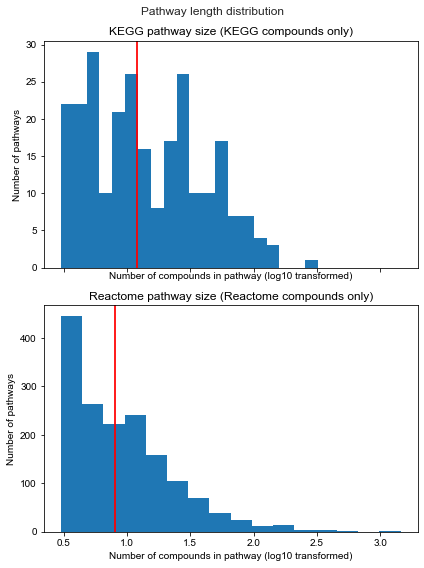

In [5]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(6,8))

pathway_length_KEGG = [len(v) for k, v in KEGG_pathway_dict.items()]
print(np.median(pathway_length_KEGG))
print(stats.describe(pathway_length_KEGG))
plt.style.use("seaborn")
plt.suptitle("Pathway length distribution")
ax1.hist(np.log10(pathway_length_KEGG), bins=20)
ax1.axvline(np.log10(np.median(pathway_length_KEGG)), c="r")
ax1.set_title("KEGG pathway size (KEGG compounds only)")
ax1.set_ylabel("Number of pathways")
ax1.set_xlabel("Number of compounds in pathway (log10 transformed)")

pathway_length_Reactome = [len(v) for k, v in Reactome_pathway_dict.items()]
print(np.median(pathway_length_Reactome))
print(stats.describe(pathway_length_Reactome))
ax2.hist(np.log10(pathway_length_Reactome), bins=16)
ax2.axvline(np.log10(np.median(pathway_length_Reactome)), c="r")
ax2.set_title("Reactome pathway size (Reactome compounds only)")
ax2.set_ylabel("Number of pathways")
ax2.set_xlabel("Number of compounds in pathway (log10 transformed)")
# plt.savefig("../Figures/pathway_size_comparison.png", dpi=300)
plt.tight_layout()

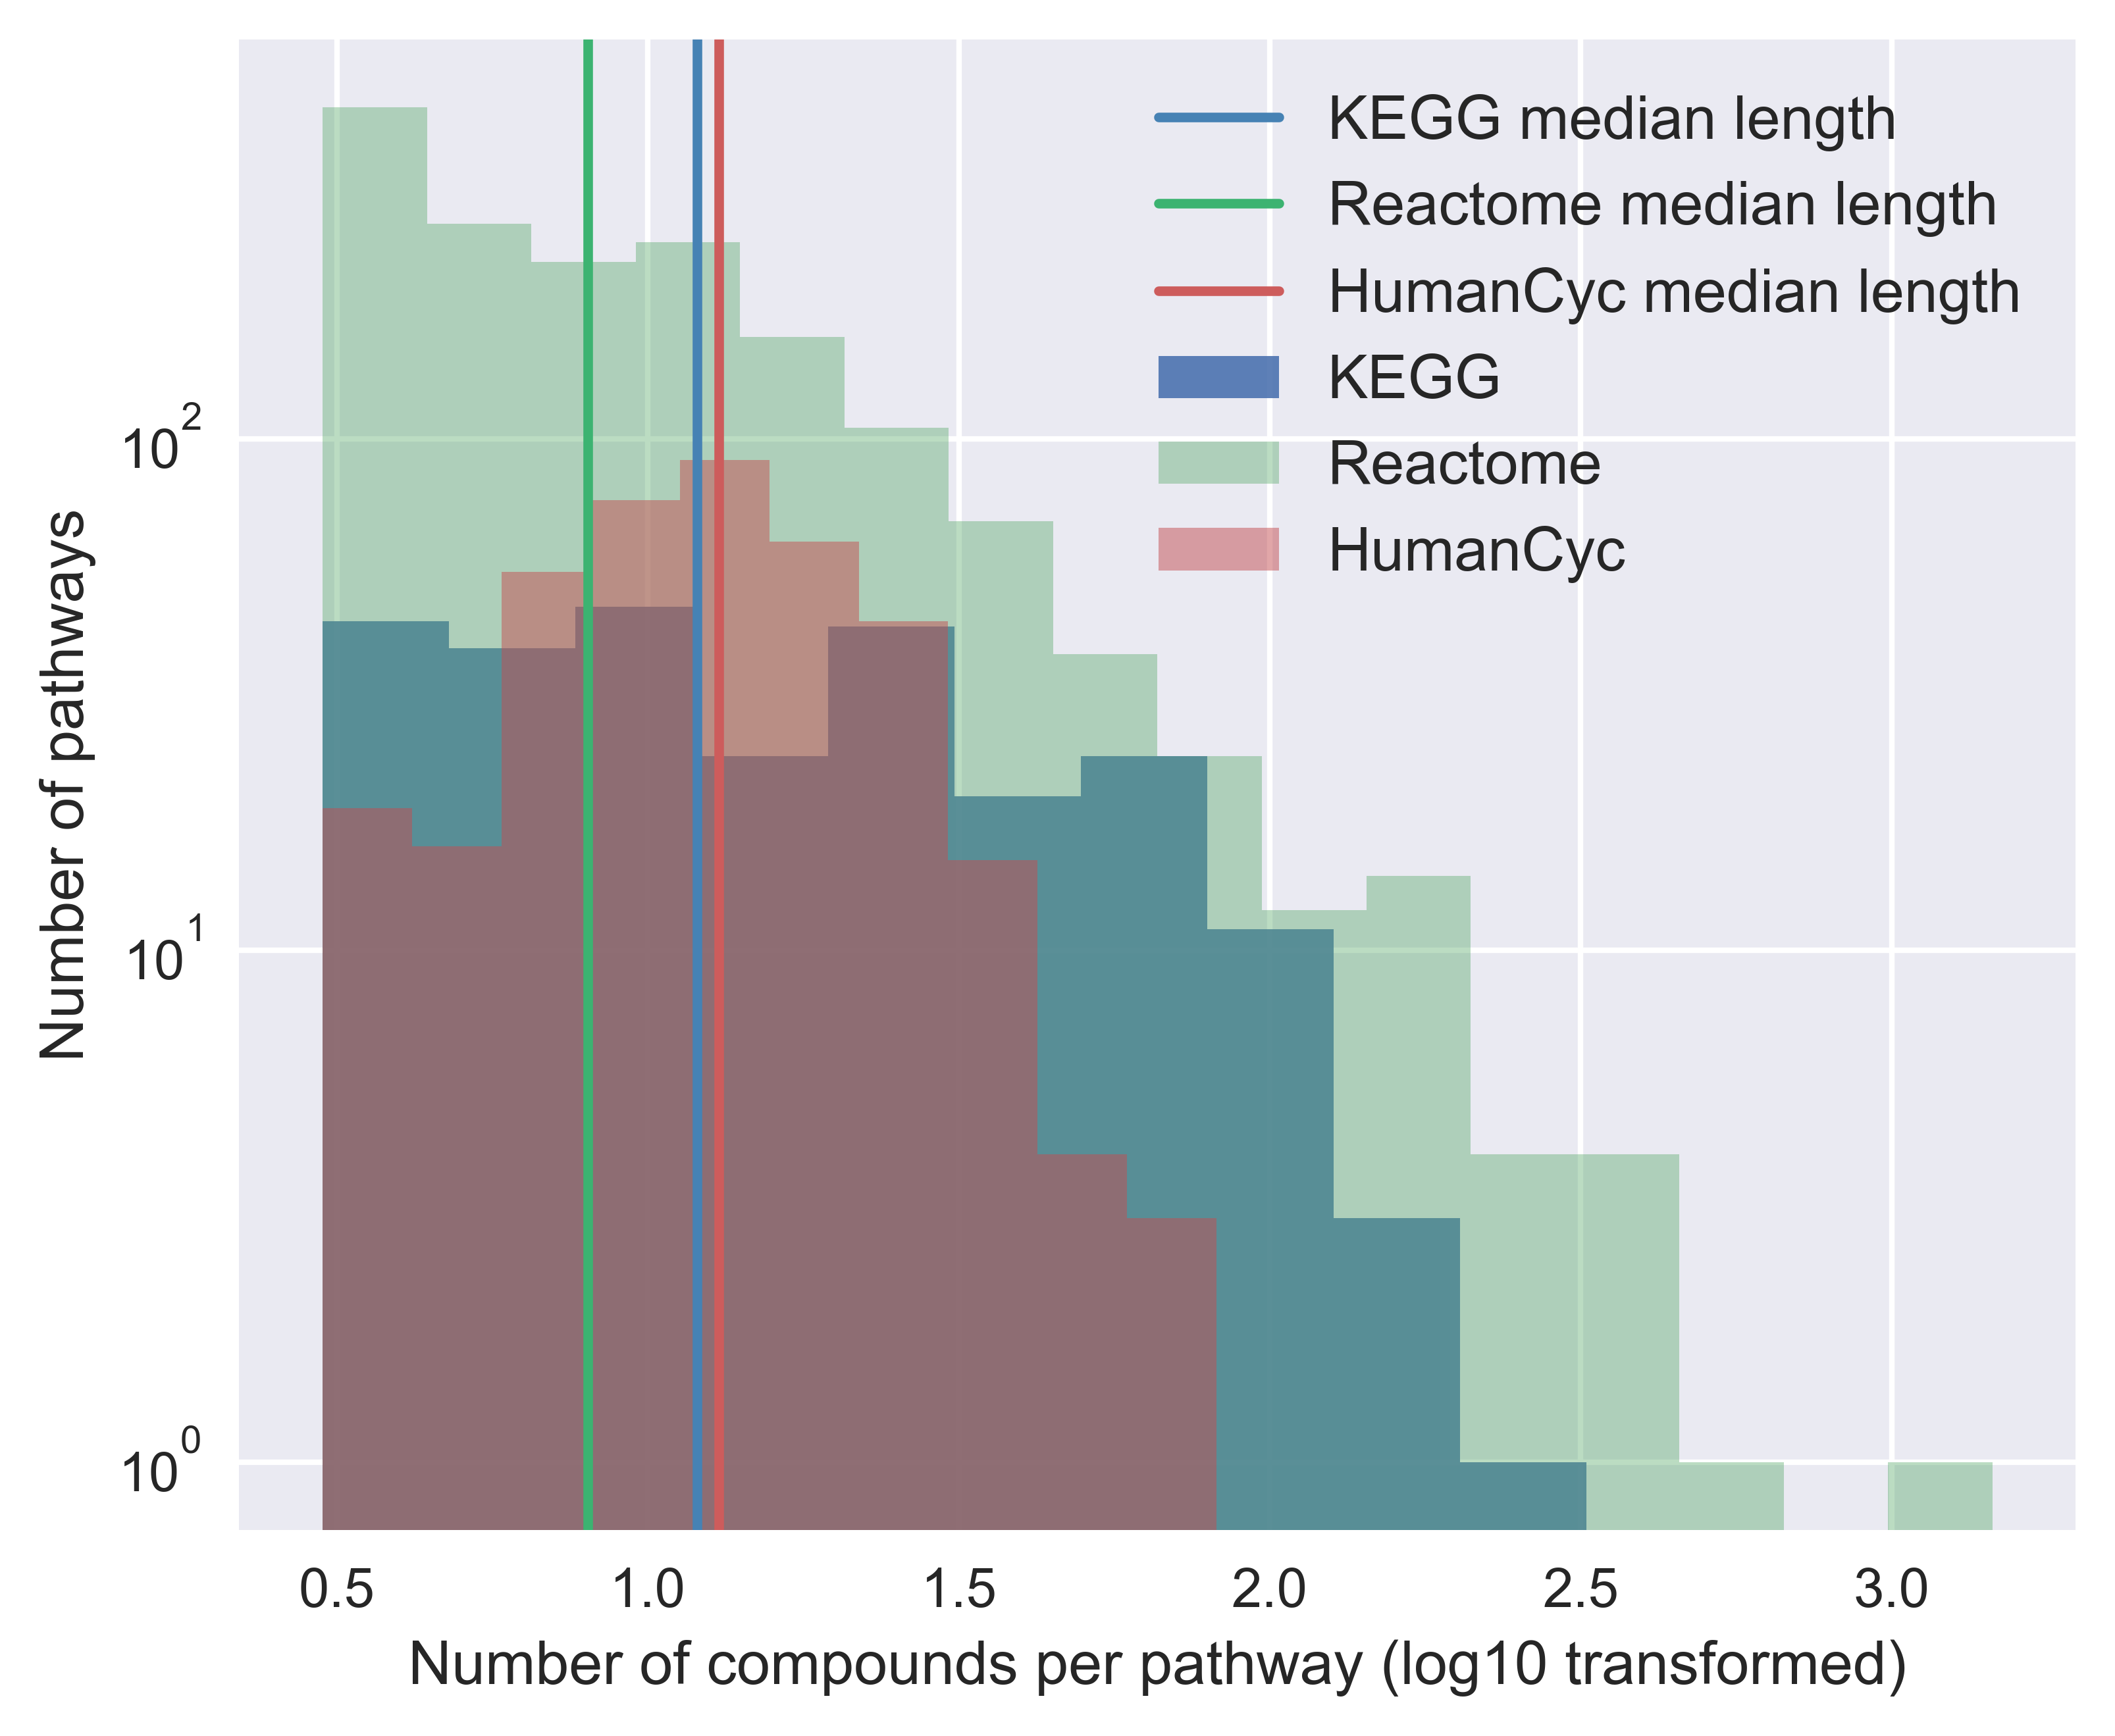

In [73]:
# Overlay hists
pathway_length_KEGG = [len(v) for k, v in KEGG_pathway_dict.items()]
pathway_length_Reactome = [len(v) for k, v in Reactome_pathway_dict.items()]
pathway_length_metacyc = [len(v) for k, v in metacyc_pathway_dict.items()]
plt.style.use("seaborn-darkgrid")

plt.figure(figsize=(6, 5), dpi=600)
plt.hist(np.log10(pathway_length_KEGG), bins=10, alpha=0.9, label="KEGG", log=True)
plt.axvline(np.log10(np.median(pathway_length_KEGG)), c="steelblue", label="KEGG median length")
plt.axvline(np.log10(np.median(pathway_length_Reactome)), c="mediumseagreen", label="Reactome median length")
plt.hist(np.log10(pathway_length_Reactome), bins=16, alpha=0.4, label="Reactome", log=True)

plt.hist(np.log10(pathway_length_metacyc), bins=10, alpha=0.5, label="HumanCyc", log=True)
plt.axvline(np.log10(np.median(pathway_length_metacyc)), c="indianred", label="HumanCyc median length")
plt.ylabel("Number of pathways", fontsize=11)
plt.xlabel("Number of compounds per pathway (log10 transformed)", fontsize=11)

# plt.yticks([0,2,5,10,20,50,100,200,400,500])

plt.legend(fontsize=11)
plt.savefig("../Figures/pathway_length_disctribution_log.png", dpi=600)
plt.show()

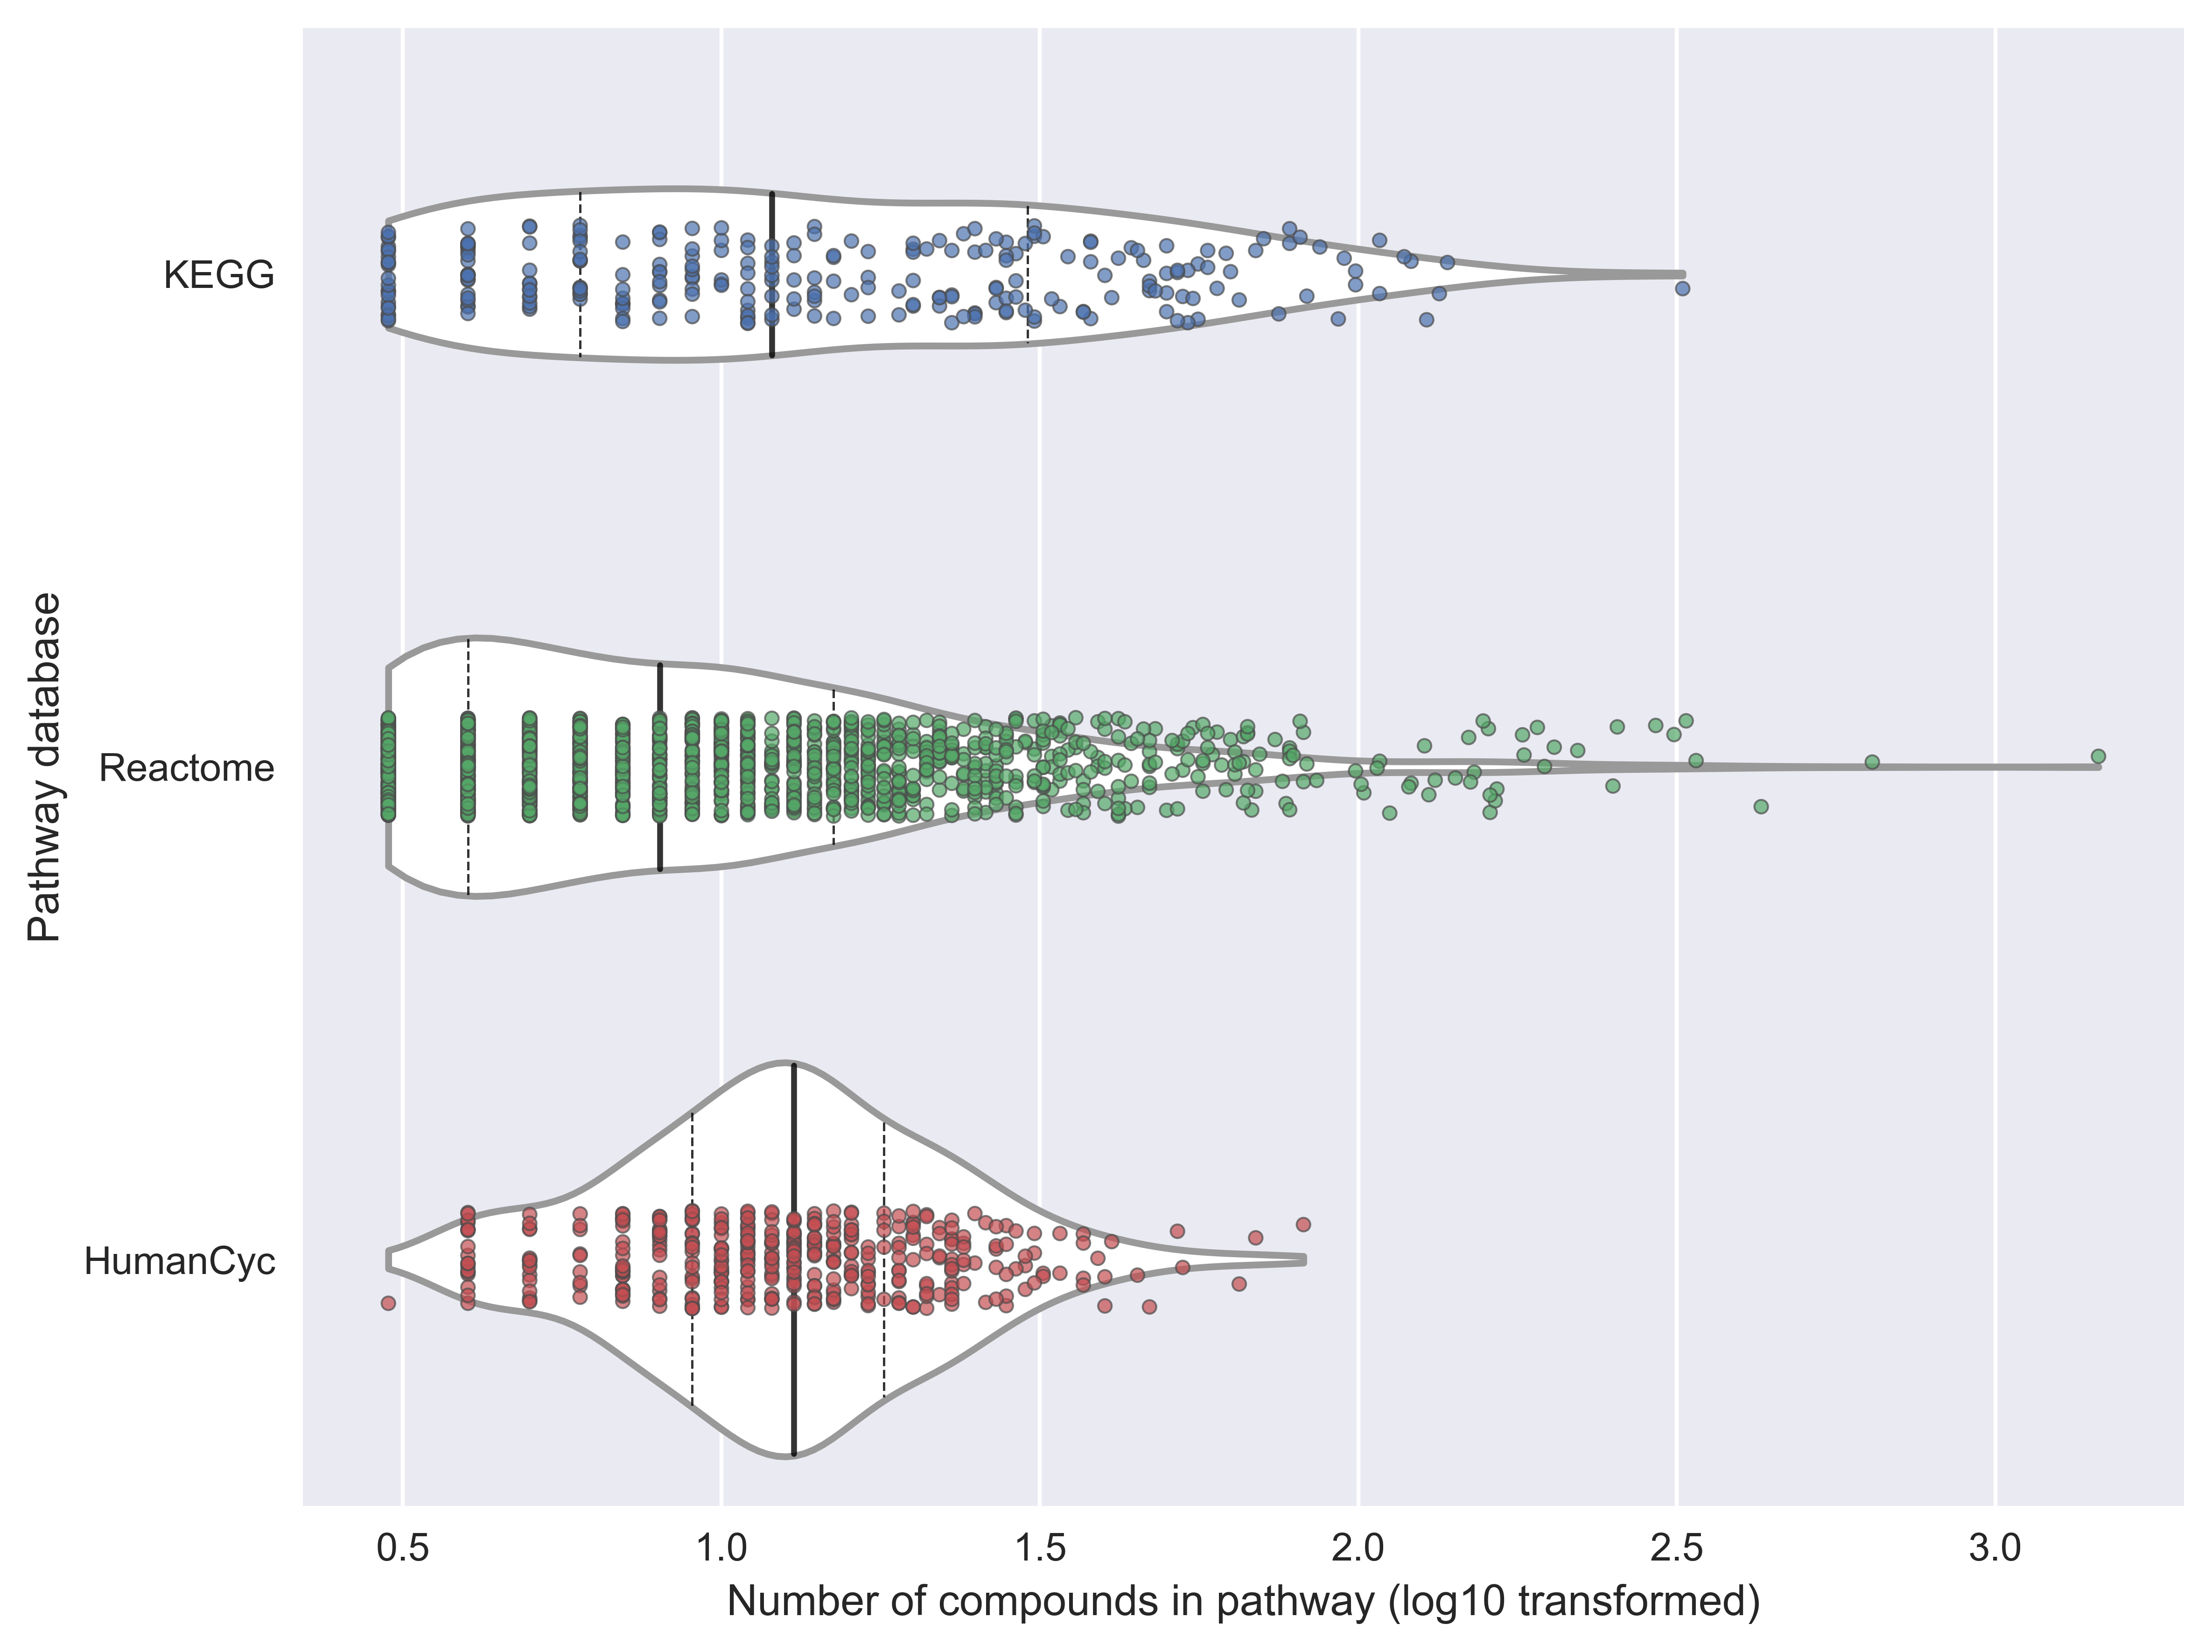

In [75]:
# Overlay hists
pathway_length_KEGG = [np.log10(len(v)) for k, v in KEGG_pathway_dict.items()]
pathway_length_Reactome = [np.log10(len(v)) for k, v in Reactome_pathway_dict.items()]
pathway_length_metacyc = [np.log10(len(v)) for k, v in metacyc_pathway_dict.items()]

df = pd.DataFrame([pathway_length_KEGG, pathway_length_Reactome, pathway_length_metacyc]).T
df.columns = ["KEGG", "Reactome", "HumanCyc"]
df = df.melt(var_name='groups', value_name='vals')
plt.style.use("seaborn-darkgrid")
fig, ax1 = plt.subplots(figsize=(8,6), dpi=600)
# sns.histplot(data=df, x=df.vals, hue=df.groups, ax=ax1)
# sns.violinplot(x=df.vals, y=df.groups, ax=ax1)
# sns.swarmplot(x=df.vals, y=df.groups, ax=ax1, s=2)
ax = sns.violinplot(x=df.vals, y=df.groups, color="white", inner="quartile", edgecolor="k", cut=0)
ax = sns.stripplot(x=df.vals, y=df.groups, size=3.5, linewidth=0.5, alpha=0.7)

for l in ax.lines:
    l.set_linestyle('--')
    l.set_linewidth(0.6)
    l.set_color('black')
    l.set_alpha(0.8)
for l in ax.lines[1::3]:
    l.set_linestyle('-')
    l.set_linewidth(1.5)
    l.set_color('black')
    l.set_alpha(0.8)

plt.ylabel("Pathway database", fontsize=11)
plt.xlabel("Number of compounds in pathway (log10 transformed)", fontsize=11)
plt.tight_layout()
plt.savefig("../Figures/pathway_length_disctribution_violin.png", dpi=600)
plt.show()

In [27]:
tips = sns.load_dataset("tips")
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [32]:
# Pathway overlap
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

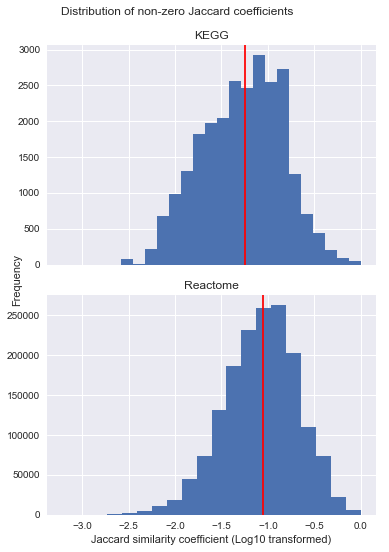

In [33]:
all_pathways_KEGG = [k for k, v in KEGG_pathway_dict.items()]
all_pathways_reactome = [k for k, v in Reactome_pathway_dict.items()]
jaccard_similarity_list_KEGG = []
jaccard_similarity_list_reactome = []
for pathway_pair in itertools.permutations(all_pathways_KEGG,2):
    jaccard_similarity_list_KEGG.append(jaccard_similarity(KEGG_pathway_dict[pathway_pair[0]], KEGG_pathway_dict[pathway_pair[1]]))
for pathway_pair in itertools.permutations(all_pathways_reactome,2):
    jaccard_similarity_list_reactome.append(jaccard_similarity(Reactome_pathway_dict[pathway_pair[0]], Reactome_pathway_dict[pathway_pair[1]]))

jaccard_non_zero_kegg = [i for i in jaccard_similarity_list_KEGG if i != 0]
jaccard_non_zero_reactome = [i for i in jaccard_similarity_list_reactome if i != 0]

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(6,8))

ax1.hist(np.log10(jaccard_non_zero_kegg), bins=20)
ax1.set_title("KEGG")
ax1.axvline(np.log10(np.median(jaccard_non_zero_kegg)), c="r")
ax2.hist(np.log10(jaccard_non_zero_reactome), bins=20)
ax2.set_title("Reactome")
ax2.axvline(np.log10(np.median(jaccard_non_zero_reactome)), c="r")
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Jaccard similarity coefficient (Log10 transformed)')
plt.ylabel('Frequency')
plt.suptitle('Distribution of non-zero Jaccard coefficients')
plt.tight_layout()
# plt.savefig("../Figures/pathway_overlap_comparison.png", dpi=300)
plt.show()

## Pathway db results comparison

In [86]:
DEM_auwerx_r, background_auwerx_r, mat_auwerx_r = process_datasets.auwerx_data(db="Reactome")
DEM_yamada_r, background_yamada_r, mat_yamada_r = process_datasets.yamada_data(db="Reactome")
DEM_stevens_r, background_stevens_r, mat_stevens_r = process_datasets.stevens_data(db="Reactome")
DEM_brown_r, background_brown_r, mat_brown_r = process_datasets.brown_data(db="Reactome")
DEM_yfgM_r, background_yfgM_r, mat_yfgM_r = process_datasets.zamboni_data("yfgM", db="Reactome")
DEM_dcuS_r, background_dcuS_r, mat_dcuS_r = process_datasets.zamboni_data("dcuS", db="Reactome")

# Import KEGG datasets
DEM_auwerx, background_auwerx, mat_auwerx = process_datasets.auwerx_data(db="KEGG")
DEM_yamada, background_yamada, mat_yamada = process_datasets.yamada_data(db="KEGG")
DEM_stevens, background_stevens, mat_stevens = process_datasets.stevens_data(db="KEGG")
DEM_brown, background_brown, mat_brown = process_datasets.brown_data(db="KEGG")
DEM_yfgM, background_yfgM, mat_yfgM = process_datasets.zamboni_data("yfgM", db="KEGG")
DEM_dcuS, background_dcuS, mat_dcuS = process_datasets.zamboni_data("dcuS", db="KEGG")

# Import BioCyc datasets
DEM_auwerx_b, background_auwerx_b, mat_auwerx_b = process_datasets.auwerx_data(db="Cyc")
DEM_yamada_b, background_yamada_b, mat_yamada_b = process_datasets.yamada_data(db="Cyc")
DEM_stevens_b, background_stevens_b, mat_stevens_b = process_datasets.stevens_data(db="Cyc")
DEM_brown_b, background_brown_b, mat_brown_b = process_datasets.brown_data(db="Cyc")
DEM_yfgM_b, background_yfgM_b, mat_yfgM_b = process_datasets.zamboni_data("yfgM", db="Cyc")
DEM_dcuS_b, background_dcuS_b, mat_dcuS_b = process_datasets.zamboni_data("dcuS", db="Cyc")

# Import KEGG pathway sets
KEGG_human_pathways = pd.read_csv("KEGG_human_pathways_compounds.csv", dtype=str, index_col=0)
KEGG_eco_pathways = pd.read_csv("KEGG_ecoMG1655_pathways_compounds.csv", dtype=str, index_col=0)
KEGG_mouse_pathways = pd.read_csv("KEGG_mouse_pathways_compounds.csv", dtype=str, index_col=0)
all_KEGG_human_bg = list(set([x for x in KEGG_human_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))
all_KEGG_eco_bg = list(set([x for x in KEGG_eco_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))
all_KEGG_mouse_bg = list(set([x for x in KEGG_mouse_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))

# Import Reactome pathway sets
Reactome_pathways = pd.read_csv("Reactome_pathway_set_all_levels.csv", dtype=str, index_col=0)
Reactome_human_pathways = Reactome_pathways[Reactome_pathways.index.str.contains("HSA")]
Reactome_eco_pathways = Reactome_pathways[Reactome_pathways.index.str.contains("ECO")]
Reactome_mouse_pathways = Reactome_pathways[Reactome_pathways.index.str.contains("MMU")]
all_reactome_human_bg = list(set([x for x in Reactome_human_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))
all_reactome_mouse_bg = list(set([x for x in Reactome_mouse_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))

# Import BioCyc pathway sets
BioCyc_human_pathways = pd.read_csv("Metacyc_human_pathways.csv", dtype=str, index_col=0)
BioCyc_eco_pathways = pd.read_csv("Metacyc_EColi_pathways.csv", dtype=str, index_col=0)
all_biocyc_human_bg = list(set([x for x in BioCyc_human_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))
all_biocyc_eco_bg = list(set([x for x in BioCyc_eco_pathways.iloc[:, 1:].values.flatten() if x is not np.nan]))

datasets = {"Labbé": [DEM_brown, background_brown, KEGG_mouse_pathways, all_KEGG_mouse_bg],
            "Yachida": [DEM_yamada, background_yamada, KEGG_human_pathways, all_KEGG_human_bg],
            "Stevens": [DEM_stevens, background_stevens, KEGG_human_pathways, all_KEGG_human_bg],
            "Quirós": [DEM_auwerx, background_auwerx, KEGG_human_pathways, all_KEGG_human_bg],
            "Fuhrer (yfgM)": [DEM_yfgM, background_yfgM, KEGG_eco_pathways, all_KEGG_eco_bg],
            "Fuhrer (dcuS)": [DEM_dcuS, background_dcuS, KEGG_eco_pathways, all_KEGG_eco_bg]}

datasets_reactome = {
    "Labbé": [DEM_brown_r, background_brown_r, Reactome_mouse_pathways, all_reactome_mouse_bg],
    "Yachida": [DEM_yamada_r, background_yamada_r, Reactome_human_pathways, all_reactome_human_bg],
    "Stevens": [DEM_stevens_r, background_stevens_r, Reactome_human_pathways, all_reactome_human_bg],
    "Quirós": [DEM_auwerx_r, background_auwerx_r, Reactome_human_pathways, all_reactome_human_bg],
    "Fuhrer (yfgM)": [DEM_yfgM_r, background_yfgM_r, Reactome_human_pathways, all_reactome_human_bg],
    "Fuhrer (dcuS)": [DEM_dcuS_r, background_dcuS_r, Reactome_human_pathways, all_reactome_human_bg]}

datasets_biocyc = {"Labbé": [DEM_brown_b, background_brown_b, BioCyc_human_pathways, all_biocyc_human_bg],
                   "Yachida": [DEM_yamada_b, background_yamada_b, BioCyc_human_pathways, all_biocyc_human_bg],
                   "Stevens": [DEM_stevens_b, background_stevens_b, BioCyc_human_pathways, all_biocyc_human_bg],
                   "Quirós": [DEM_auwerx_b, background_auwerx_b, BioCyc_human_pathways, all_biocyc_human_bg],
                   "Fuhrer (yfgM)": [DEM_yfgM_b, background_yfgM_b, BioCyc_eco_pathways, all_biocyc_eco_bg],
                   "Fuhrer (dcuS)": [DEM_dcuS_b, background_dcuS_b, BioCyc_eco_pathways, all_biocyc_eco_bg]}

print("Data processing complete.")

/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/cw2019/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Data processing complete.


In [87]:
db_dict = {"KEGG": datasets, "Reactome": datasets_reactome, "BioCyc": datasets_biocyc}
results_dicts = dict.fromkeys(db_dict.keys(), {})
for d in db_dict.keys():
    d_set = db_dict[d]
    res_datasets = {}
    for i in d_set.keys():
        ora_res = utils.over_representation_analysis(d_set[i][0], d_set[i][1], d_set[i][2])
        significant_ids = ora_res[ora_res["P-value"] <= 0.1]["Pathway_ID"]
        res_datasets[i] = significant_ids.tolist()
    results_dicts[d] = res_datasets
        

In [16]:
# convert all IDS to KEGG
from bioservices import *


In [70]:
# get reactome ChEBI compounds for each pathway
def process_paths(pathway_df):
    KEGG_pathways = pathway_df.dropna(axis=0, how='all', subset=pathway_df.columns.tolist()[1:])
    pathways = KEGG_pathways.index.tolist()
    pathway_names = KEGG_pathways["Pathway_name"].tolist()
    pathway_dict = {}

    for pathway in pathways:
        pathway_compounds = KEGG_pathways.loc[pathway, :].tolist()
        pathway_compounds = [str(i) for i in pathway_compounds if str(i) != "nan"]
        cpds = pathway_compounds[1:]
        if len(cpds) > 2:
            pathway_dict[pathway] = cpds
    return pathway_dict

Reactome_pathways = pd.read_csv("Reactome_pathway_set_all_levels.csv", dtype=str, index_col=0)
Reactome_pathways = process_paths(Reactome_pathways)


In [29]:
from bioservices import *
ch = ChEBI()

reactome_sig_path_cpds = {}

for name, v in results_dicts["Reactome"].items():
    pathways = v
    all_compounds_in_pathways = []
    for pathway in pathways:
        pathway_compounds = Reactome_pathways[pathway]
        pathway_compounds_kegg = []
        for cpd in pathway_compounds:
            try:
                kegg_id = ch.conv("CHEBI:"+cpd, "KEGG COMPOUND accession")
                pathway_compounds_kegg.append(kegg_id[0])
            except (ValueError, AttributeError):
                continue
        print(pathway, len(pathway_compounds), len(pathway_compounds_kegg))
        all_compounds_in_pathways = all_compounds_in_pathways + pathway_compounds_kegg
    reactome_sig_path_cpds[name] = list(set(all_compounds_in_pathways))
    
print(reactome_sig_path_cpds.keys())

NameError: name 'results_dicts' is not defined

In [86]:
for k, v in reactome_sig_path_cpds.items():
    print(k, v)

Labbé ['C01996', 'C00249', 'C00712', 'C04230', 'C00267', 'C06427', 'C01712', 'C06429', 'C06428', 'C06426', 'C08362', 'C06424', 'C02679', 'C16537', 'C16522', 'C03242', 'C16527', 'C16513', 'C01996', 'C00033', 'C00080', 'C00584', 'C00639', 'C02198', 'C02165', 'C05952', 'C00075', 'C00077', 'C00249', 'C00355', 'C00044', 'C00712', 'C01245', 'C02166', 'C01585', 'C00035', 'C00015', 'C00641', 'C00388', 'C04637', 'C00547', 'C06427', 'C01712', 'C06429', 'C06428', 'C06426', 'C05951', 'C08362', 'C00780', 'C06424', 'C00788', 'C00038', 'C00076', 'C00205', 'C00058', 'C00163', 'C00246', 'C02679', 'C16537', 'C16522', 'C03242', 'C16527', 'C16513', 'C06314', 'C00114', 'C00080', 'C00086', 'C00791', 'C03642', 'C00115', 'C01330', 'C11310', 'C07151', 'C07401', 'C00080', 'C00019', 'C00077', 'C00581', 'C00021', 'C00300', 'C02305', 'C01330', 'C00001', 'C00881', 'C00239', 'C00526', 'C00105', 'C00299', 'C00364', 'C00055', 'C00475', 'C00106', 'C00365', 'C00214', 'C02067', 'C00178', 'C01168', 'C00305', 'C00672', 'C0

In [89]:
KEGG_human_pathways = process_paths(pd.read_csv("KEGG_human_pathways_compounds.csv", dtype=str, index_col=0))
KEGG_eco_pathways = process_paths(pd.read_csv("KEGG_ecoMG1655_pathways_compounds.csv", dtype=str, index_col=0))
KEGG_mouse_pathways = process_paths(pd.read_csv("KEGG_mouse_pathways_compounds.csv", dtype=str, index_col=0))
kegg_pathways_merged = {**KEGG_human_pathways, **KEGG_eco_pathways}
all_kegg_pathways_merged = {**kegg_pathways_merged, **KEGG_mouse_pathways}

kegg_sig_path_cpds = {}

for name, v in results_dicts["KEGG"].items():
    pathways = v
    all_compounds_in_pathways = []
    for pathway in pathways:
        pathway_compounds = all_kegg_pathways_merged[pathway]
        print(pathway, len(pathway_compounds))
        all_compounds_in_pathways = all_compounds_in_pathways + pathway_compounds
    kegg_sig_path_cpds[name] = list(set(all_compounds_in_pathways))

mmu00220 23
mmu00240 70
mmu00260 50
mmu00471 13
mmu00564 56
mmu00591 30
mmu00730 32
mmu00970 52
mmu01040 122
mmu01210 134
mmu01230 129
mmu04217 13
mmu04724 23
mmu04727 20
mmu04921 19
mmu04974 46
mmu05030 32
mmu05031 44
mmu05143 8
hsa00130 73
hsa00280 47
hsa00290 23
hsa00350 79
hsa00400 34
hsa00630 65
hsa00970 52
hsa01210 134
hsa01230 129
hsa01240 333
hsa04916 6
hsa05131 16
hsa05230 55
hsa00071 57
hsa00260 50
hsa01040 122
hsa04714 30
hsa04923 22
hsa00030 38
hsa00040 56
hsa00051 56
hsa00052 48
hsa00053 50
hsa00220 23
hsa00230 102
hsa00240 70
hsa00250 29
hsa00260 50
hsa00270 66
hsa00280 47
hsa00330 78
hsa00340 47
hsa00410 32
hsa00430 22
hsa00471 13
hsa00480 42
hsa00520 117
hsa00524 83
hsa00620 31
hsa00630 65
hsa00650 42
hsa00740 20
hsa00760 55
hsa00770 30
hsa00860 140
hsa00920 48
hsa00970 52
hsa00980 121
hsa01200 108
hsa01210 134
hsa01230 129
hsa01240 333
hsa02010 115
hsa04022 17
hsa04068 5
hsa04080 45
hsa04122 21
hsa04150 4
hsa04152 25
hsa04216 39
hsa04727 20
hsa04742 35
hsa04918 48
hsa0

In [43]:
print(kegg_sig_path_cpds.keys())

dict_keys(['Labbé', 'Yachida', 'Stevens', 'Quirós', 'Fuhrer (yfgM)', 'Fuhrer (dcuS)'])


In [9]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [14]:
def overlap_coefficient(list1, list2):
    # Szymkiewicz–Simpson coefficient
    intersection = len(list(set(list1).intersection(list(set(list2)))))
    smaller_set = min(len(list1), len(list2))
    return float(intersection) / smaller_set

In [158]:
def sorensen_dice_coefficient(list1, list2):
    # Sørensen–Dice coefficient
    intersection = len(list(set(list1).intersection(list2)))
    total_Set_size = len(list1) + len(list2)
    return float(2*intersection) / total_Set_size

0.08034188034188035
0.02890932982917214
0.10465116279069768
0.185473411154345
0.10366972477064221
0.11707317073170732


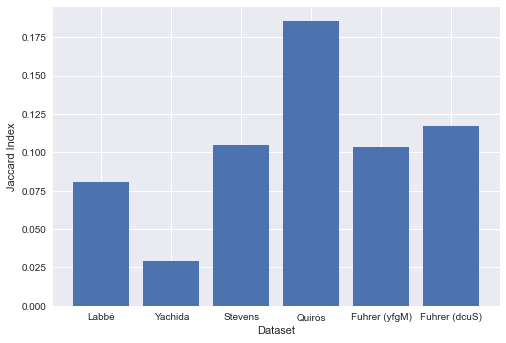

In [123]:
res = {}
for dset in kegg_sig_path_cpds.keys():
    JI = jaccard_similarity(kegg_sig_path_cpds[dset], reactome_sig_path_cpds[dset])
    res[dset] = JI
    print(JI)

plt.figure()
plt.bar(res.keys(), res.values())
plt.xlabel("Dataset")
plt.ylabel("Jaccard Index")
plt.show()

0.618421052631579
0.30985915492957744
0.234375
0.411313518696069
0.29736842105263156
0.33410672853828305


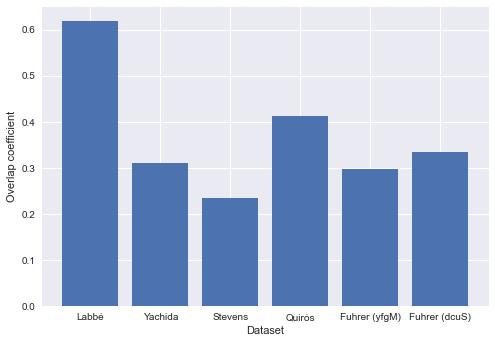

In [157]:
res = {}
for dset in kegg_sig_path_cpds.keys():
    JI = overlap_coefficient(kegg_sig_path_cpds[dset], reactome_sig_path_cpds[dset])
    print(JI)
    res[dset] = JI

plt.figure()
plt.bar(res.keys(), res.values())
plt.xlabel("Dataset")
plt.ylabel("Overlap coefficient")
plt.show()

0.14873417721518986
0.0561941251596424
0.18947368421052632
0.31291028446389496
0.18786367414796343
0.2096069868995633


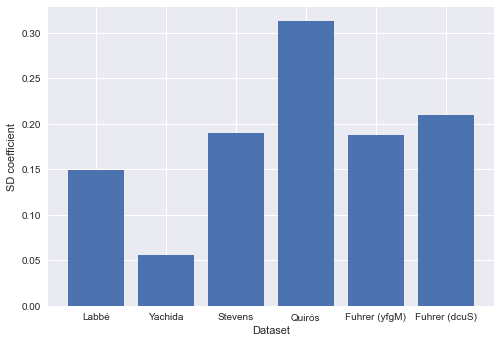

In [159]:
res = {}
for dset in kegg_sig_path_cpds.keys():
    JI = sorensen_dice_coefficient(kegg_sig_path_cpds[dset], reactome_sig_path_cpds[dset])
    print(JI)
    res[dset] = JI

plt.figure()
plt.bar(res.keys(), res.values())
plt.xlabel("Dataset")
plt.ylabel("SD coefficient")
plt.show()

In [52]:
db_dict = {"KEGG": datasets, "Reactome": datasets_reactome, "BioCyc": datasets_biocyc}
results_dicts = dict.fromkeys(db_dict.keys(), {})
for d in db_dict.keys():
    d_set = db_dict[d]
    res_datasets = {}
    for i in d_set.keys():
        ora_res = utils.over_representation_analysis(d_set[i][0], d_set[i][1], d_set[i][2])
        significant_ids = ora_res[ora_res["P-value"] <= 0.1]["Pathway_name"]
        print(d, i, significant_ids.tolist())
        print()
        res_datasets[i] = significant_ids.tolist()
    results_dicts[d] = res_datasets
        

KEGG Labbé ['Arginine biosynthesis - Mus musculus (mouse)', 'Pyrimidine metabolism - Mus musculus (mouse)', 'Glycine, serine and threonine metabolism - Mus musculus (mouse)', 'D-Glutamine and D-glutamate metabolism - Mus musculus (mouse)', 'Glycerophospholipid metabolism - Mus musculus (mouse)', 'Linoleic acid metabolism - Mus musculus (mouse)', 'Thiamine metabolism - Mus musculus (mouse)', 'Aminoacyl-tRNA biosynthesis - Mus musculus (mouse)', 'Biosynthesis of unsaturated fatty acids - Mus musculus (mouse)', '2-Oxocarboxylic acid metabolism - Mus musculus (mouse)', 'Biosynthesis of amino acids - Mus musculus (mouse)', 'Necroptosis - Mus musculus (mouse)', 'Glutamatergic synapse - Mus musculus (mouse)', 'GABAergic synapse - Mus musculus (mouse)', 'Oxytocin signaling pathway - Mus musculus (mouse)', 'Protein digestion and absorption - Mus musculus (mouse)', 'Cocaine addiction - Mus musculus (mouse)', 'Amphetamine addiction - Mus musculus (mouse)', 'African trypanosomiasis - Mus musculus 

Reactome Labbé ['Synthesis, secretion, and inactivation of Glucagon-like Peptide-1 (GLP-1)', 'Incretin synthesis, secretion, and inactivation', 'G alpha (q) signalling events', 'Creatine metabolism', 'Pyrimidine salvage']

Reactome Yachida ['PAOs oxidise polyamines to amines', 'Hydrolysis of LPE', 'Triglyceride catabolism', 'Signaling by VEGF', 'Metabolism of nitric oxide: NOS3 activation and regulation', 'eNOS activation', 'Nitric oxide stimulates guanylate cyclase', 'Platelet homeostasis', 'VEGFA-VEGFR2 Pathway', 'VEGFR2 mediated vascular permeability', 'Metal sequestration by antimicrobial proteins', 'Triglyceride biosynthesis', 'Triglyceride metabolism', 'Iron uptake and transport']

Reactome Stevens ['Effects of PIP2 hydrolysis', 'Signal Transduction', 'Generic Transcription Pathway', 'Cellular responses to stress', 'SUMOylation', 'SUMO E3 ligases SUMOylate target proteins', 'Glyoxylate metabolism and glycine degradation', 'SUMOylation of intracellular receptors', 'G alpha (q) sig

Reactome Fuhrer (dcuS) ['Neurotransmitter release cycle', 'Synthesis of CL', 'Synthesis of PE', 'Glycosaminoglycan metabolism', 'Keratan sulfate/keratin metabolism', 'Disease', 'Sphingolipid de novo biosynthesis', 'Digestion of dietary carbohydrate', 'Peptide hormone metabolism', 'Amino acid transport across the plasma membrane', 'Metabolism of proteins', 'Sialic acid metabolism', 'cGMP effects', 'Transport of vitamins, nucleosides, and related molecules', 'Sphingolipid metabolism', 'Biosynthesis of the N-glycan precursor (dolichol lipid-linked oligosaccharide, LLO) and transfer to a nascent protein', 'Asparagine N-linked glycosylation', 'Synthesis of UDP-N-acetyl-glucosamine', 'Synthesis of substrates in N-glycan biosythesis', 'Variant SLC6A14 may confer susceptibility towards obesity', 'SLC transporter disorders', 'Defective SLC27A4 causes ichthyosis prematurity syndrome (IPS)', 'Disorders of transmembrane transporters', 'Intestinal saccharidase deficiencies', 'Diseases of carbohydra

In [31]:
# all kegg significant pathway compounds
Reactome_pathways = pd.read_csv("Reactome_pathway_set.csv", dtype=str, index_col=0)
Reactome_mouse_pathways = Reactome_pathways[Reactome_pathways.index.str.contains("HSA")]
Reactome_pathways = process_paths(Reactome_mouse_pathways)
ch = ChEBI()

reactome_sig_path_cpds = {}

Reactome_pathways_toKEGG = {}

# Labbe dataset only
pathways = list(Reactome_pathways.keys())
for pathway in pathways:
    pathway_compounds = Reactome_pathways[pathway]
    pathway_compounds_kegg = []
    for cpd in pathway_compounds:
        try:
            kegg_id = ch.conv("CHEBI:" + cpd, "KEGG COMPOUND accession")
            pathway_compounds_kegg.append(kegg_id[0])
        except (ValueError, AttributeError):
            continue
    print(pathway)
    Reactome_pathways_toKEGG[pathway] = pathway_compounds_kegg

print("Done.")

R-HSA-109704
R-HSA-110312
R-HSA-110320
R-HSA-110328
R-HSA-110329
R-HSA-110330
R-HSA-110331
R-HSA-110362
R-HSA-110373
R-HSA-110381
R-HSA-111446
R-HSA-111447
R-HSA-111932
R-HSA-111933
R-HSA-111957
R-HSA-111995
R-HSA-112043
R-HSA-112122
R-HSA-112126
R-HSA-112310
R-HSA-112311
R-HSA-112314
R-HSA-112382
R-HSA-113418
R-HSA-113501
R-HSA-114508
R-HSA-114516
R-HSA-114604
R-HSA-114608
R-HSA-1169091
R-HSA-1169092
R-HSA-1169408
R-HSA-1170546
R-HSA-1181150
R-HSA-1221632
R-HSA-1222387
R-HSA-1222449
R-HSA-1222538
R-HSA-1222541
R-HSA-1222556
R-HSA-1227986
R-HSA-1234174
R-HSA-1234176
R-HSA-1236382
R-HSA-1236394
R-HSA-1236973
R-HSA-1236974
R-HSA-1236977
R-HSA-1236978
R-HSA-1237044
R-HSA-1237112
R-HSA-1247673
R-HSA-1250196
R-HSA-1250342
R-HSA-1250347
R-HSA-1257604
R-HSA-1266695
R-HSA-1268020
R-HSA-1295596
R-HSA-1300642
R-HSA-1307965
R-HSA-1362409
R-HSA-1368082
R-HSA-1368108
R-HSA-1369007
R-HSA-1369062
R-HSA-139853
R-HSA-139910
R-HSA-140180
R-HSA-140342
R-HSA-140837
R-HSA-140875
R-HSA-141333
R-HSA-141334
R

R-HSA-5218921
R-HSA-5221030
R-HSA-5223345
R-HSA-5250924
R-HSA-5250955
R-HSA-5250958
R-HSA-5250968
R-HSA-5250971
R-HSA-5250981
R-HSA-5250982
R-HSA-5250989
R-HSA-5250992
R-HSA-525793
R-HSA-5263617
R-HSA-532668
R-HSA-5334118
R-HSA-5336415
R-HSA-5357905
R-HSA-5358346
R-HSA-5358493
R-HSA-5358565
R-HSA-5358606
R-HSA-5362517
R-HSA-5362768
R-HSA-5365859
R-HSA-5368286
R-HSA-5389840
R-HSA-5419276
R-HSA-5423646
R-HSA-549127
R-HSA-5576890
R-HSA-5576892
R-HSA-5576893
R-HSA-5578749
R-HSA-5578775
R-HSA-5578996
R-HSA-5578997
R-HSA-5578998
R-HSA-5578999
R-HSA-5579000
R-HSA-5579002
R-HSA-5579004
R-HSA-5579005
R-HSA-5579006
R-HSA-5579007
R-HSA-5579009
R-HSA-5579010
R-HSA-5579011
R-HSA-5579012
R-HSA-5579013
R-HSA-5579014
R-HSA-5579015
R-HSA-5579016
R-HSA-5579017
R-HSA-5579019
R-HSA-5579021
R-HSA-5579024
R-HSA-5579026
R-HSA-5579027
R-HSA-5579028
R-HSA-5579030
R-HSA-5601884
R-HSA-5602498
R-HSA-5603041
R-HSA-5607763
R-HSA-5607764
R-HSA-561048
R-HSA-5610787
R-HSA-5617833
R-HSA-5619036
R-HSA-5619041
R-HSA-5619

In [33]:
import pickle

with open('Reactome_pathways_toKEGG_HSA.pickle', 'wb') as handle:
    pickle.dump(Reactome_pathways_toKEGG, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
# with open('Reactome_pathways_toKEGG_MMU.pickle', 'rb') as handle:
#     Reactome_pathways_toKEGG = pickle.load(handle)

In [12]:
labbe_all_kegg_sig_pathway_cpds = set(kegg_sig_path_cpds["Labbé"])
# discard pathways which have no compounds in common
keep_reactome_paths = []
for k, v in Reactome_pathways_toKEGG.items():
    kegg_overlap = len(labbe_all_kegg_sig_pathway_cpds.intersection(set(v)))
    if kegg_overlap != 0:
        keep_reactome_paths.append(k)
        
print(len(keep_reactome_paths))

453


In [23]:
Reactome_pathways_toKEGG_filt = {k: v for k, v in Reactome_pathways_toKEGG.items() if k in keep_reactome_paths}
Reactome_pathway_JI = {}
for k, v in Reactome_pathways_toKEGG_filt.items():
    print(v)
    JI = jaccard_similarity(set(v), set(kegg_sig_path_cpds["Labbé"]))
    Reactome_pathway_JI[k] = JI

['C00458', 'C04283', 'C00013']
['C00429', 'C00106', 'C00178', 'C06502']
['C00076']
['C00076']
['C00001', 'C00020', 'C00575', 'C00076']
['C00001', 'C00219', 'C00157', 'C04230', 'C00076']
['C00001', 'C00044', 'C01245', 'C00035', 'C00165', 'C04637']
['C00001', 'C00249', 'C00219', 'C00189', 'C00712', 'C11695', 'C06424', 'C02679', 'C16512']
['C00115', 'C00780', 'C01330', 'C00238', 'C00076']
['C00075', 'C00044', 'C00063']
['C01245', 'C00641', 'C00076']
['C00641', 'C02737', 'C00076']
['C00044', 'C01245', 'C05981', 'C00035', 'C00641', 'C04637']
['C00044', 'C00035', 'C00305', 'C00780', 'C00076', 'C00013']
['C00641', 'C02737', 'C00076']
['C00044', 'C00035', 'C00641']
['C00080', 'C00007', 'C00044', 'C00327', 'C00005', 'C00533', 'C00006', 'C00704', 'C14818', 'C00038']
['C00007', 'C00011', 'C00026', 'C14818', 'C00072']
['C00007', 'C00011', 'C00026', 'C14818', 'C00072']
['C00080', 'C00007', 'C00005', 'C00006', 'C00704']
['C00001', 'C00080', 'C00007', 'C00011', 'C00288', 'C00032', 'C00115', 'C00038']

In [22]:
sorted_Reactome_pathway_JI = {k: v for k, v in sorted(Reactome_pathway_JI.items(), key=lambda item: item[1], reverse=True)}

{'R-MMU-416476': 0.04152249134948097,
 'R-MMU-73621': 0.037037037037037035,
 'R-MMU-499943': 0.031141868512110725,
 'R-MMU-73614': 0.028622540250447227,
 'R-MMU-1483191': 0.023214285714285715,
 'R-MMU-381771': 0.021352313167259787,
 'R-MMU-2046106': 0.02112676056338028,
 'R-MMU-1660661': 0.021052631578947368,
 'R-MMU-197264': 0.02097902097902098,
 'R-MMU-1483213': 0.01971326164874552,
 'R-MMU-1483166': 0.01950354609929078,
 'R-MMU-8850843': 0.019434628975265017,
 'R-MMU-500753': 0.01601423487544484,
 'R-MMU-2046105': 0.015957446808510637,
 'R-MMU-977347': 0.01436265709156194,
 'R-MMU-1482798': 0.014336917562724014,
 'R-MMU-75105': 0.014134275618374558,
 'R-MMU-83936': 0.014109347442680775,
 'R-MMU-71403': 0.014084507042253521,
 'R-MMU-75876': 0.014084507042253521,
 'R-MMU-389661': 0.013986013986013986,
 'R-MMU-71064': 0.013986013986013986,
 'R-MMU-1660662': 0.01386481802426343,
 'R-MMU-418594': 0.013136288998357963,
 'R-MMU-71288': 0.012567324955116697,
 'R-MMU-936837': 0.0125448028673

In [164]:
reactome_cpds_added = []
for k, v in sorted_Reactome_pathway_JI.items():
    pathway_cpds = Reactome_pathways_toKEGG[k]
    reactome_cpds_added = reactome_cpds_added + pathway_cpds
    JI = jaccard_similarity(set(reactome_cpds_added), set(kegg_sig_path_cpds["Quirós"]))
    print(JI)

# import itertools

# lst = keep_reactome_paths
# combs = []

# for i in range(1, len(lst)+1):
#     els = [list(x) for x in itertools.combinations(lst, i)]
#     combs.extend(els)

0.013945380592678676
0.027793862188766647
0.039884393063583816
0.041040462427745665
0.04440599769319493
0.044956772334293946
0.046444954128440366
0.047212741751990896
0.05221339387060159
0.05328798185941043
0.05596382136800452
0.05765969474279254
0.06218202374222725
0.06253521126760564
0.0647887323943662
0.06471581316826111
0.06692913385826772
0.0719910011248594
0.07247191011235955
0.07278835386338185
0.07718120805369127
0.07919687674288901
0.08245711123408965
0.08423913043478261
0.08586956521739131
0.08690928843020097
0.08888888888888889
0.0910569105691057
0.0915989159891599
0.09253246753246754
0.09415584415584416
0.09577922077922078
0.0957274202271498
0.09621621621621622
0.09675675675675675
0.09670448406266882
0.09724473257698542
0.097784981091302
0.09935205183585313
0.1009719222462203
0.1025364274150027
0.10517799352750809
0.10721982758620689
0.11039310716208939
0.11135018827326519
0.11117078410311493
0.11654135338345864
0.11654135338345864
0.11654135338345864
0.11654135338345864
0.

## Add in genes to pathways and compare similarity

In [19]:
#combine reactome genes with metabolite pathways
reactome_geneset = pd.read_csv("../ReactomePathways.txt", sep="\t", dtype="str", header=None)
reactome_geneset = reactome_geneset.rename(columns={0: "Pathway_name", 1: "ID"})
reactome_geneset = reactome_geneset.set_index("ID")

In [20]:
reactome_genes_all = process_paths(reactome_geneset)

In [149]:
# stevens data test
significant_paths = results_dicts["Reactome"]["Quirós"]
significant_genes = [v for k, v in reactome_genes_all.items() if k in significant_paths]
reactome_genes_compounds_stevens = reactome_sig_path_cpds["Quirós"] + [item for sublist in significant_genes for item in sublist]
reactome_genes_compounds_stevens

['C03878',
 'C00836',
 'C05455',
 'C01061',
 'C16528',
 'C02984',
 'C01652',
 'C07398',
 'C04006',
 'C00584',
 'C00451',
 'C11481',
 'C15614',
 'C01036',
 'C00032',
 'C01188',
 'C00319',
 'C01222',
 'C00696',
 'C01086',
 'C00096',
 'C00527',
 'C00337',
 'C06125',
 'C04734',
 'C13650',
 'C03205',
 'C00237',
 'C01647',
 'C01453',
 'C05467',
 'C00986',
 'C03508',
 'C18178',
 'C01643',
 'C04850',
 'C04730',
 'C01528',
 'C11278',
 'C00109',
 'C12144',
 'C01213',
 'C01259',
 'C01026',
 'C04520',
 'C14180',
 'C02140',
 'C03512',
 'C11720',
 'C00506',
 'C01176',
 'C07108',
 'C07443',
 'C05336',
 'C04677',
 'C05263',
 'C05488',
 'C00957',
 'C00951',
 'C00857',
 'C03345',
 'C00387',
 'C00909',
 'C00113',
 'C01246',
 'C02291',
 'C08357',
 'C14717',
 'C00110',
 'C00601',
 'C00016',
 'C11378',
 'C07297',
 'C00454',
 'C00144',
 'C03542',
 'C00785',
 'C00009',
 'C03511',
 'C02094',
 'C11766',
 'C05860',
 'C14769',
 'C00262',
 'C03492',
 'C00315',
 'C17938',
 'C14767',
 'C03242',
 'C01194',
 'C00218',

In [91]:
import requests
import re
url = 'http://rest.kegg.jp/list/pathway/hsa'
# change organism name
data = requests.get(url)
pathways = data.text
pathways = pathways.split("\n")
pathways = filter(None, pathways)
pathway_dict = dict()

for path in pathways:
    path = path.split("\t")
    name = path[1]
    pathid = re.search(r"path:(.*)", path[0]).group(1)
    pathway_dict[pathid] = name

# get compounds for each pathway
base_url = 'http://rest.kegg.jp/get/'
#eco00010

pathway_ids = [*pathway_dict]

pathway_names = list(pathway_dict.values())
pathway_compound_mapping = dict.fromkeys(pathway_ids)
for i in pathway_ids:
    print(i)
    current_url = base_url + i 
    page = requests.get(current_url)
    lines = page.text.split("\n")
    gene_lines = []
    start_idx = 0
    end_idx = 0
    for num, l in enumerate(lines):
        if "GENE" in l:
            start_idx = num
        if "COMPOUND" in l:
            end_idx = num
            break
        elif "REFERENCE" in l:
            end_idx = num
            break
    gene_lines = lines[start_idx:end_idx]
    gene_ids = []
    for x in gene_lines:
        if x == gene_lines[0]:
            x = x.split()
            gene_ids.append(x[2][:-1])
        else:
            x = x.split()
            gene_ids.append(x[1][:-1])

    pathway_compound_mapping[i] = gene_ids


df = pd.DataFrame.from_dict(pathway_compound_mapping, orient='index')
df.insert(0, 'Pathway_name', pathway_names)
df.to_csv("KEGG_HSA_pathways_genes.csv")
print(df.head)

hsa00010
40 107
hsa00020
26 56
hsa00030
21 51
hsa00040
9 43
hsa00051
21 54
hsa00052
38 69
hsa00053
6 36
hsa00061
13 31
hsa00062
11 38
hsa00071
27 70
hsa00072
8 18
hsa00100
25 45
hsa00120
20 37
hsa00130
28 39
hsa00140
71 132
hsa00190
41 174
hsa00220
23 45
hsa00230
101 231
hsa00232
7 13
hsa00240
50 107
hsa00250
17 54
hsa00260
42 82
hsa00270
20 70
hsa00280
33 81
hsa00290
6 10
hsa00310
21 84
hsa00330
41 92
hsa00340
32 54
hsa00350
48 84
hsa00360
26 43
hsa00380
45 87
hsa00400
9 15
hsa00410
9 39
hsa00430
7 18
hsa00440
8 14
hsa00450
9 26
hsa00471
8 13
hsa00472
5 6
hsa00480
22 79
hsa00500
38 74
hsa00510
22 72
hsa00511
18 0
hsa00512
11 43
hsa00513
8 47
hsa00514
9 56
hsa00515
20 43
hsa00520
18 66
hsa00524
5 10
hsa00531
28 47
hsa00532
16 36
hsa00533
7 21
hsa00534
15 39
hsa00561
25 86
hsa00562
22 95
hsa00563
17 42
hsa00564
39 137
hsa00565
13 62
hsa00590
171 232
hsa00591
6 35
hsa00592
6 31
hsa00600
39 88
hsa00601
9 36
hsa00603
10 25
hsa00604
10 25
hsa00620
18 65
hsa00630
11 41
hsa00640
10 44
hsa0065

In [77]:
pathway_compound_mapping["hsa04010"]

['CACNA1A',
 'CACNA1B',
 'CACNA1C',
 'CACNA1D',
 'CACNA1E',
 'CACNA1F',
 'CACNA1G',
 'CACNA1H',
 'CACNA1I',
 'CACNA1S',
 'CACNA2D1',
 'CACNA2D2',
 'CACNA2D3',
 'CACNA2D4',
 'CACNB1',
 'CACNB2',
 'CACNB3',
 'CACNB4',
 'CACNG1',
 'CACNG2',
 'CACNG3',
 'CACNG4',
 'CACNG5',
 'CACNG6',
 'CACNG7',
 'CACNG8',
 'PRKACA',
 'PRKACB',
 'PRKACG',
 'PRKCA',
 'PRKCB',
 'PRKCG',
 'GNA12',
 'GNG12',
 'PPP3CA',
 'PPP3CB',
 'PPP3CC',
 'PPP3R1',
 'PPP3R2',
 'RASGRF1',
 'RASGRF2',
 'RASGRP1',
 'RASGRP2',
 'RASGRP3',
 'RASGRP4',
 'RAPGEF2',
 'NF1',
 'RASA1',
 'RASA2',
 'RAP1A',
 'RAP1B',
 'EGF',
 'TGFA',
 'EREG',
 'AREG',
 'FGF1',
 'FGF2',
 'FGF3',
 'FGF4',
 'FGF17',
 'FGF6',
 'FGF7',
 'FGF8',
 'FGF9',
 'FGF10',
 'FGF16',
 'FGF5',
 'FGF18',
 'FGF20',
 'FGF22',
 'FGF19',
 'FGF21',
 'FGF23',
 'NGF',
 'BDNF',
 'NTF3',
 'NTF4',
 'INS',
 'IGF1',
 'IGF2',
 'PDGFA',
 'PDGFB',
 'PDGFC',
 'PDGFD',
 'CSF1',
 'KITLG',
 'FLT3LG',
 'VEGFA',
 'VEGFB',
 'PGF',
 'VEGFC',
 'VEGFD',
 'HGF',
 'ANGPT1',
 'ANGPT2',
 'ANGPT4',


In [146]:
pathway_dict["hsa4714"]

['NDUFB8',
 'ASHI',
 'CI-ASHI',
 'MC1DN32',
 'NADH:ubiquinone oxidoreductase subunit B8']

In [118]:
results_dicts["KEGG"]["Quirós"]

['hsa00071', 'hsa00260', 'hsa01040', 'hsa04714', 'hsa04923']

In [150]:
significant_paths_kegg = ["hsa"+i.replace("hsa", "").lstrip('0') for i in results_dicts["KEGG"]["Quirós"]]
significant_genes_kegg = [v for k, v in pathway_dict.items() if k in significant_paths_kegg]
kegg_genes_compounds_stevens = kegg_sig_path_cpds["Quirós"] + [item for sublist in significant_genes_kegg for item in sublist]
kegg_genes_compounds_stevens

['C17245',
 'C18239',
 'C14788',
 'C05793',
 'C02656',
 'C04122',
 'C00032',
 'C01222',
 'C19889',
 'C01438',
 'C17255',
 'C04752',
 'C03618',
 'C01110',
 'C11278',
 'C01768',
 'C06028',
 'C14803',
 'C00431',
 'C02405',
 'C16638',
 'C17583',
 'C00430',
 'C02350',
 'C15882',
 'C18064',
 'C00034',
 'C00888',
 'C00734',
 'C06509',
 'C05516',
 'C21511',
 'C00417',
 'C03981',
 'C00218',
 'C00376',
 'C22159',
 'C00132',
 'C14799',
 'C00185',
 'C15976',
 'C04546',
 'C05944',
 'C01380',
 'C02630',
 'C00865',
 'C02465',
 'C04022',
 'C00429',
 'C01004',
 'C03906',
 'C02527',
 'C06406',
 'C00295',
 'C00364',
 'C00037',
 'C00386',
 'C01096',
 'C04462',
 'C00250',
 'C01726',
 'C00905',
 'C00357',
 'C14787',
 'C02330',
 'C01146',
 'C01598',
 'C11851',
 'C00001',
 'C06144',
 'C16518',
 'C03614',
 'C14843',
 'C00684',
 'C15563',
 'C08401',
 'C00062',
 'C05723',
 'C01879',
 'C21955',
 'C01368',
 'C00508',
 'C20562',
 'C16589',
 'C00502',
 'C16255',
 'C04282',
 'C01297',
 'C01118',
 'C04349',
 'C01732',

In [155]:
JI = overlap_coefficient(set(kegg_genes_compounds_stevens), set(reactome_genes_compounds_stevens))
print(JI)


0.235140771637122


In [6]:
import upsetplot

ModuleNotFoundError: No module named 'upsetplot'

# Upset plot of pathway intersection

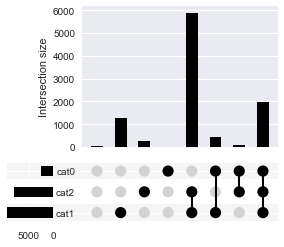

In [10]:
from upsetplot import generate_counts
example = generate_counts()
from upsetplot import plot
plt.style.use("seaborn")
plot(example)
plt.show()  

In [11]:
print(res)

NameError: name 'res' is not defined

<Figure size 576x576 with 0 Axes>

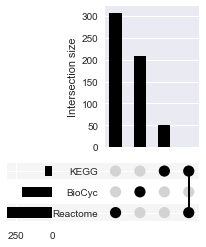

In [42]:
import upsetplot
categories = [["KEGG"], ["Reactome"], ["BioCyc"], ["KEGG", "Reactome"]]
data = [50, 307, 208, res["Quirós"]]
upset_data = upsetplot.from_memberships(categories, data)
fig = plt.figure(figsize=(8,8))

ax1 = plot(upset_data)
plt.show()

In [32]:
print(res.values())

dict_values([0.08034188034188035, 0.02890932982917214, 0.10465116279069768, 0.185473411154345, 0.10366972477064221, 0.11707317073170732])


In [65]:
biocyc_sig_paths_quiros = results_dicts["BioCyc"]["Quirós"]
human_cyc = process_paths(BioCyc_human_pathways)

In [69]:
biocyc_sig_cpds = [v for k, v in human_cyc.items() if k in biocyc_sig_paths_quiros]
biocyc_sig_cpds = [item for sublist in biocyc_sig_cpds for item in sublist]
biocyc_sig_cpds


In [73]:
biocyc_kegg_cpds = pd.read_csv("biocyc2kegg.txt", sep="\t")
biocyc_kegg_cpds = biocyc_kegg_cpds["Kegg"].tolist()

In [77]:
biocyc_vs_kegg = jaccard_similarity(kegg_sig_path_cpds["Stevens"], biocyc_kegg_cpds)
biocyc_vs_reactome = jaccard_similarity(reactome_sig_path_cpds["Stevens"], biocyc_kegg_cpds)

AttributeError: module 'matplotlib.pyplot' has no attribute 'yabel'

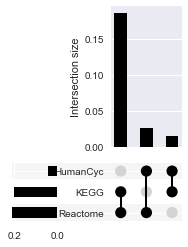

In [122]:
import upsetplot
categories = [["KEGG", "Reactome"], ["HumanCyc", "KEGG"], ["HumanCyc", "Reactome"]]
data = [res["Quirós"], biocyc_vs_kegg, biocyc_vs_reactome]
upset_data = upsetplot.from_memberships(categories, data)

plot(upset_data)
plt.savefig("upset_test.png", dpi=600)
plt.show()

# Comparing analogous pathways from KEGG and Reactome based on ComPath mappings

In [2]:
#import ComPath mapping
compath_mapping_all = pd.read_csv("all_mappings_compath.tsv", sep="\t", header=None, names=["Name1", "ID1", "db1", "relationship", "Name2", "ID2", "db2"])
# filter only KEGG/Reactome

compath_mapping_all = compath_mapping_all[compath_mapping_all["db1"].isin(["kegg", "reactome"])]
compath_mapping_all = compath_mapping_all[compath_mapping_all["db2"].isin(["kegg", "reactome"])]

In [3]:
compath_mapping_equivalent = compath_mapping_all[compath_mapping_all["relationship"] == "equivalentTo"]
print(compath_mapping_equivalent.shape)
compath_mapping_equivalent = compath_mapping_equivalent[compath_mapping_equivalent["db1"] != compath_mapping_equivalent["db2"]]
print(compath_mapping_equivalent.shape)

(60, 7)
(58, 7)


In [4]:
compath_mapping_equivalent
kegg_paths_to_compare = compath_mapping_equivalent["ID1"].str.replace("path:", "").tolist()
reactome_paths_to_compare = compath_mapping_equivalent["ID2"].str.replace("path:", "").tolist()
equivalent_paths = dict(zip(kegg_paths_to_compare, reactome_paths_to_compare))

In [5]:
with open('Reactome_pathways_toKEGG_HSA.pickle', 'rb') as handle:
    Reactome_pathways_toKEGG = pickle.load(handle)
    
len(Reactome_pathways_toKEGG)
Reactome_pathways_toKEGG = {k: v for k, v in Reactome_pathways_toKEGG.items() if len(v) != 0}

In [8]:
KEGG_human_pathways = process_paths(pd.read_csv("KEGG_human_pathways_compounds.csv", dtype=str, index_col=0))

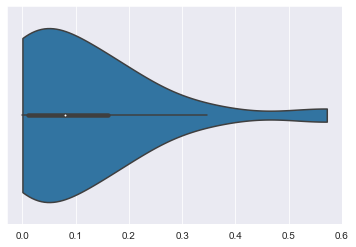

0.08051529790660225
0.1607142857142857 0.011415863602668644


In [32]:
x_vals = []

for k, v in equivalent_paths.items():
    if k in KEGG_human_pathways.keys() and v in Reactome_pathways_toKEGG.keys():
        kegg_path = KEGG_human_pathways[k]
        reactome_path = Reactome_pathways_toKEGG[v]
        JI = jaccard_similarity(kegg_path, reactome_path)
        x_vals.append(JI)
        
sns.violinplot(x=x_vals, cut=0)
plt.show()
print(np.median(x_vals))
q75, q25 = np.percentile(x_vals, [75 ,25])
print(q75, q25)

hsa01200 R-HSA-71387
hsa01212 R-HSA-8978868
hsa01100 R-HSA-1430728
55


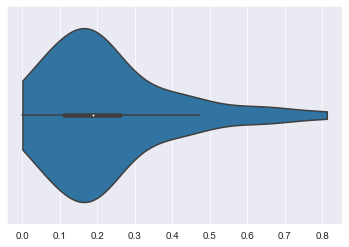

0.18787878787878787
0.25908733280881197 0.11125226860254084


In [93]:
# genes ONLY
kegg_genes_hsa_paths = process_paths(pd.read_csv("KEGG_HSA_pathways_genes.csv", dtype=str, index_col=0))
x_vals = []
count = 0
for k, v in equivalent_paths.items():
    if k in kegg_genes_hsa_paths.keys() and v in reactome_genes_all.keys():
        count += 1
        kegg_path = kegg_genes_hsa_paths[k]
        reactome_path = reactome_genes_all[v]
        JI = jaccard_similarity(kegg_path, reactome_path)
        x_vals.append(JI)
    else:
        print(k ,v)
    
print(count)        
sns.violinplot(x=x_vals, cut=0)
plt.show()
print(np.median(x_vals))
q75, q25 = np.percentile(x_vals, [75 ,25])
print(q75, q25)

0.3333333333333333 hsa02010 R-HSA-1369007
0.2 hsa00590 R-HSA-2142753
0.6666666666666666 hsa04136 R-HSA-1632852
0.35 hsa00020 R-HSA-71403
0.0 hsa04922 R-HSA-163359
0.6666666666666666 hsa00480 R-HSA-174403
0.15384615384615385 hsa00563 R-HSA-162710
0.3333333333333333 hsa04911 R-HSA-422356
0.058823529411764705 hsa00591 R-HSA-2046105
0.375 hsa00310 R-HSA-71064
0.0 hsa04916 R-HSA-5662702
0.0 hsa04217 R-HSA-5675482
0.5 hsa04151 R-HSA-198203
0.26666666666666666 hsa00030 R-HSA-71336
0.0 hsa04917 R-HSA-1170546
0.35294117647058826 hsa00620 R-HSA-70268
0.8 hsa04015 R-HSA-392517
0.42857142857142855 hsa00740 R-HSA-196843
0.4 hsa00730 R-HSA-196819
0.6 hsa04918 R-HSA-209968
0.03571428571428571 hsa00592 R-HSA-2046106
0.0 hsa04150 R-HSA-165159
22


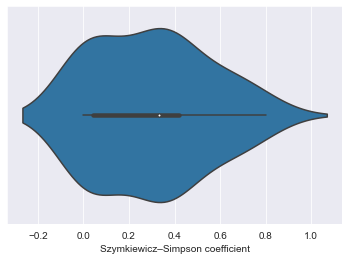

0.3333333333333333


In [16]:
kegg_paths_to_compare = compath_mapping_equivalent["ID1"].str.replace("path:", "").tolist()
reactome_paths_to_compare = compath_mapping_equivalent["ID2"].str.replace("path:", "").tolist()
equivalent_paths = dict(zip(kegg_paths_to_compare, reactome_paths_to_compare))
x_vals_ss_equivalent = []
n_comparisons = 0
for k, v in equivalent_paths.items():
    if k in KEGG_human_pathways.keys() and v in Reactome_pathways_toKEGG.keys():
        kegg_path = KEGG_human_pathways[k]
        reactome_path = Reactome_pathways_toKEGG[v]
        OC = overlap_coefficient(kegg_path, reactome_path)
        print(OC, k, v)
        x_vals_ss_equivalent.append(OC)
        n_comparisons += 1
        
print(n_comparisons)
sns.set_style("darkgrid")
sns.violinplot(x=x_vals_ss_equivalent)
plt.xlabel("Szymkiewicz–Simpson coefficient")
plt.show()
print(np.median(x_vals_ss_equivalent))

## Comparing equivalent and subset of pathways from KEGG and Reactome

In [104]:
kegg_paths_to_compare = compath_mapping_all["ID1"].str.replace("path:", "").tolist()
reactome_paths_to_compare = compath_mapping_all["ID2"].str.replace("path:", "").tolist()
equivalent_or_subset_paths = dict(zip(kegg_paths_to_compare, reactome_paths_to_compare))
print(len(equivalent_or_subset_paths))

509


0.007246376811594203 R-HSA-2978092 hsa01210
0.008547008547008548 hsa02010 R-HSA-1369007
0.0 R-HSA-5679001 hsa02010
0.0 R-HSA-5679096 hsa02010
0.008620689655172414 R-HSA-5683329 hsa02010
0.0 R-HSA-5678520 hsa02010
0.0 R-HSA-5690338 hsa02010
0.0 R-HSA-5679090 hsa02010
0.0 R-HSA-5678771 hsa02010
0.0 R-HSA-5684045 hsa02010
0.0 R-HSA-5682294 hsa02010
0.0 R-HSA-5683371 hsa02010
0.0 R-HSA-5682113 hsa02010
0.0 R-HSA-5688399 hsa02010
0.0 R-HSA-1369062 hsa02010
0.0 R-HSA-5683678 hsa02010
0.00819672131147541 R-HSA-382556 hsa02010
0.037037037037037035 R-HSA-163680 hsa04152
0.05263157894736842 R-HSA-8862803 hsa05010
0.2564102564102564 R-HSA-379726 hsa00970
0.2631578947368421 R-HSA-379716 hsa00970
0.024096385542168676 hsa00590 R-HSA-2142753
0.024096385542168676 R-HSA-70688 hsa00330
0.1935483870967742 hsa00220 R-HSA-70635
0.011363636363636364 hsa04976 R-HSA-8935690
0.02857142857142857 R-HSA-1614603 hsa00270
0.036231884057971016 R-HSA-70635 hsa01230
0.05303030303030303 R-HSA-2046105 hsa01040
0.0543478

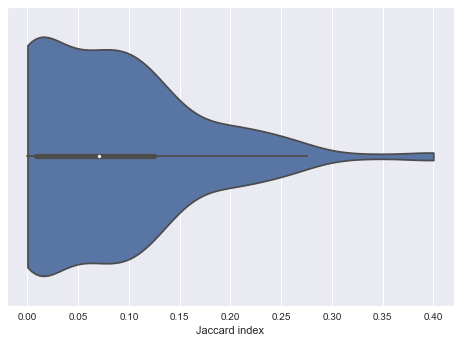

In [107]:
x_vals = []
n_comparisons = 0
for k, v in equivalent_or_subset_paths.items():
    kegg = 0
    reactome = 0
    if k.startswith("R-HSA"):
        reactome = k
        kegg = v
    else:
        kegg = k
        reactome = v
    if kegg in KEGG_human_pathways.keys() and reactome in Reactome_pathways_toKEGG.keys():
        n_comparisons += 1
        kegg_path = KEGG_human_pathways[kegg]
        reactome_path = Reactome_pathways_toKEGG[reactome]
        JI = jaccard_similarity(kegg_path, reactome_path)
        print(JI, k, v)
        x_vals.append(JI)

        
print(n_comparisons)
sns.set_style("darkgrid")
sns.violinplot(x=x_vals, cut=0)
plt.xlabel("Jaccard index")
plt.show()

0.2 R-HSA-2978092 hsa01210
0.3333333333333333 hsa02010 R-HSA-1369007
0.0 R-HSA-5679001 hsa02010
0.0 R-HSA-5679096 hsa02010
0.5 R-HSA-5683329 hsa02010
0.0 R-HSA-5678520 hsa02010
0.0 R-HSA-5690338 hsa02010
0.0 R-HSA-5679090 hsa02010
0.0 R-HSA-5678771 hsa02010
0.0 R-HSA-5684045 hsa02010
0.0 R-HSA-5682294 hsa02010
0.0 R-HSA-5683371 hsa02010
0.0 R-HSA-5682113 hsa02010
0.0 R-HSA-5688399 hsa02010
0.0 R-HSA-1369062 hsa02010
0.0 R-HSA-5683678 hsa02010
0.125 R-HSA-382556 hsa02010
0.3333333333333333 R-HSA-163680 hsa04152
0.3333333333333333 R-HSA-8862803 hsa05010
0.43478260869565216 R-HSA-379726 hsa00970
0.45454545454545453 R-HSA-379716 hsa00970
0.2 hsa00590 R-HSA-2142753
0.2857142857142857 R-HSA-70688 hsa00330
0.42857142857142855 hsa00220 R-HSA-70635
0.1111111111111111 hsa04976 R-HSA-8935690
0.3333333333333333 R-HSA-1614603 hsa00270
0.35714285714285715 R-HSA-70635 hsa01230
0.4117647058823529 R-HSA-2046105 hsa01040
0.22727272727272727 R-HSA-75105 hsa00061
0.2692307692307692 R-HSA-75876 hsa01040
0.

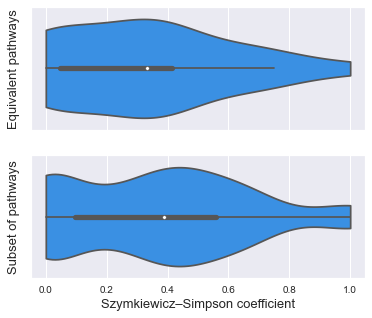

In [108]:
x_vals = []
n_comparisons = 0
for k, v in equivalent_or_subset_paths.items():
    kegg = 0
    reactome = 0
    if k.startswith("R-HSA"):
        reactome = k
        kegg = v
    else:
        kegg = k
        reactome = v
    if kegg in KEGG_human_pathways.keys() and reactome in Reactome_pathways_toKEGG.keys():
        n_comparisons += 1
        kegg_path = KEGG_human_pathways[kegg]
        reactome_path = Reactome_pathways_toKEGG[reactome]
        OC = overlap_coefficient(kegg_path, reactome_path)
        print(OC, k, v)
        x_vals.append(OC)

res_df = pd.DataFrame([x_vals_ss_equivalent, x_vals]).T
res_df = res_df.rename(columns={0:"Equivalent pathways", 1:"Subset of pathways"}, )

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,5))
sns.violinplot(x=x_vals, cut=0, ax=ax2, color="dodgerblue")
ax2.set_ylabel("Subset of pathways", fontsize=13)
sns.violinplot(x=x_vals_ss_equivalent, cut=0, ax=ax1, color="dodgerblue")
ax1.set_ylabel("Equivalent pathways", fontsize=13)

# sns.set_style("darkgrid")
# sns.violinplot(x=res_df, cut=0)
plt.xlabel("Szymkiewicz–Simpson coefficient", fontsize=13)
# plt.savefig("../Figures/ComPath_KEGG_Reactome_comparison.png", dpi=600)
plt.show()

In [93]:
OC = overlap_coefficient(KEGG_human_pathways["hsa00030"], Reactome_pathways_toKEGG["R-HSA-71336"])
OC

0.3333333333333333

In [94]:
for i in KEGG_human_pathways["hsa00030"]:
    if i in Reactome_pathways_toKEGG["R-HSA-71336"]:
        print(i, "in Reactome")
    else:
        print(i, "not present in Reactome")
# KEGG_human_pathways["hsa00020"]

C01151 not present in Reactome
C00668 not present in Reactome
C00118 not present in Reactome
C00022 not present in Reactome
C00257 not present in Reactome
C00198 not present in Reactome
C00031 not present in Reactome
C00221 not present in Reactome
C00345 not present in Reactome
C00204 not present in Reactome
C03752 not present in Reactome
C04442 not present in Reactome
C00117 not present in Reactome
C00119 not present in Reactome
C00620 not present in Reactome
C00121 in Reactome
C00279 not present in Reactome
C01218 not present in Reactome
C05382 not present in Reactome
C01801 not present in Reactome
C00673 in Reactome
C00118 not present in Reactome
C05378 not present in Reactome
C01172 not present in Reactome
C01236 in Reactome
C06473 not present in Reactome
C05345 not present in Reactome
C00672 in Reactome
C00577 not present in Reactome
C00258 not present in Reactome
C00631 not present in Reactome
C00231 not present in Reactome
C00231 not present in Reactome
C00199 in Reactome
C06019

In [145]:
len(KEGG_human_pathways["hsa00020"])

23

In [96]:
len(Reactome_pathways_toKEGG["R-HSA-71336"])

15

In [156]:
Reactome_pathways_toKEGG["R-HSA-71403"]

['C00451',
 'C00010',
 'C00024',
 'C00022',
 'C00001',
 'C00080',
 'C00044',
 'C00016',
 'C00005',
 'C00011',
 'C00026',
 'C00248',
 'C00035',
 'C00006',
 'C00122',
 'C00305',
 'C00824',
 'C00036',
 'C00158',
 'C00149']